In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from pipe import select, where, sort

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)

# Metrics
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('EvaluationResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta, average, display_false_negatives=True, threshold=None):
    pred = (model.predict_proba(X_test)[:,1] > threshold).astype(int) if threshold else model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

In [2]:
from sklearn.utils import resample
def downsampling(dataframe, target, value):
    data0 = dataframe[dataframe[target]==value]
    data1 = dataframe[dataframe[target]!=value]
    n = len(data0)
    down = resample(data1, n_samples=n, random_state=404)
    return pd.concat([data0, down], axis=0)

In [3]:
# Attack Detection
training_df_down = downsampling(training_df_scaled_enc_le_clean, 'is_attack', True)
X_train_is_attack = training_df_down.drop(['target', 'is_attack', 'target_group'], axis=1)
y_train_is_attack = training_df_down.is_attack
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'is_attack', 'target_group'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack

# Attack Classification
X_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].drop(['target', 'is_attack', 'target_group'], axis=1)
y_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].target_group
X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'is_attack', 'target_group'], axis=1)
y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

In [4]:
# Create individual models for voting classification
adaboost_is_attack = AdaBoostClassifier(
    learning_rate=1.0,
    n_estimators=200,
    algorithm='SAMME',
    random_state=404
)

gradient_boost_is_attack = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=404
)

neural_network_is_attack = MLPClassifier(
    hidden_layer_sizes=(64, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=128,
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000
)

In [31]:
# Voting Classifier
voting_classifier = VotingClassifier([
    ('AdaBoost', adaboost_is_attack),
    ('GradinetBoost', gradient_boost_is_attack),
    ('Neural Network', neural_network_is_attack),
], voting='soft', n_jobs=-1).fit(X_train_is_attack, y_train_is_attack)

In [32]:
threshold = 0.375
result_is_attack = evaluate_model(voting_classifier, X_test_is_attack, y_true_is_attack, display_false_negatives=True, beta=10, average='binary', threshold=threshold)


-- Testing Results --
Accuracy    on Verification Data:	0.785939
Fbeta scroe on Verification Data:	0.981377

              precision    recall  f1-score   support

       False       0.99      0.66      0.79     47913
        True       0.64      0.99      0.78     29378

    accuracy                           0.79     77291
   macro avg       0.81      0.82      0.79     77291
weighted avg       0.86      0.79      0.79     77291

False negatives: 394 (1.341% out of 29378 attacks, 0.510% overall)



In [33]:
y_pred_is_attack_proba = voting_classifier.predict_proba(X_test_is_attack)[:,1]
y_pred_is_attack = (y_pred_is_attack_proba > threshold).astype(int)

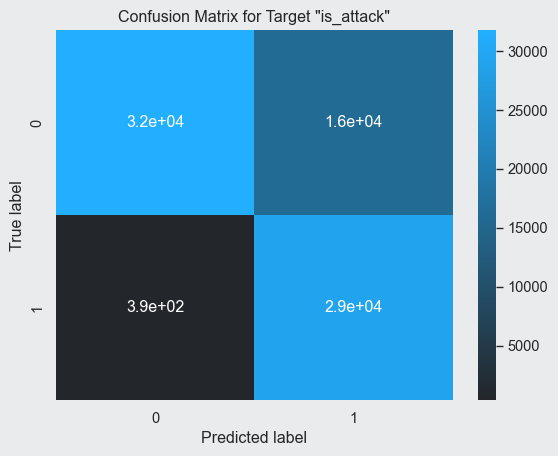

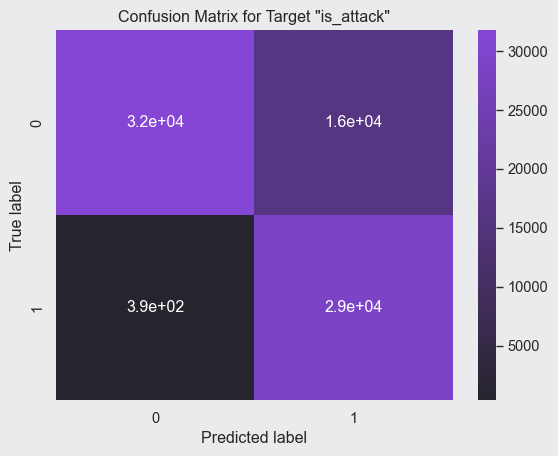

In [34]:
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack, 'is_attack')

In [35]:
# Create individual models for voting classification

random_forest_attack_group = RandomForestClassifier(
	criterion='gini',
	max_depth=20,
	n_estimators=20,
	n_jobs=-1,
	random_state=404
)

gradient_boost_attack_group = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=404
)

neural_network_attack_group = MLPClassifier(
    hidden_layer_sizes=(64, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=128,
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000
)

In [40]:
# Voting Classifier
voting_classifier = VotingClassifier([
    ('AdaBoost', adaboost_is_attack),
    ('GradinetBoost', gradient_boost_is_attack),
    #('Neural Network', neural_network_is_attack),
], voting='soft', n_jobs=-1).fit(X_train_attack_group, y_train_attack_group)

In [41]:
#threshold = 0.375
result_attack_group = evaluate_model(voting_classifier, X_test_attack_group, y_true_attack_group, display_false_negatives=False, beta=10, average='macro')#, threshold=threshold)


-- Testing Results --
Accuracy    on Verification Data:	0.885050
Fbeta scroe on Verification Data:	0.646584

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     23747
           2       0.50      0.92      0.65      3041
           3       0.97      0.23      0.37      2533
           4       0.47      0.49      0.48        57

    accuracy                           0.89     29378
   macro avg       0.73      0.65      0.61     29378
weighted avg       0.93      0.89      0.88     29378



In [42]:
#y_pred_is_attack_proba = voting_classifier.predict_proba(X_test_is_attack)[:,1]
#y_pred_is_attack = (y_pred_is_attack_proba > threshold).astype(int)
y_pred_attack_group = voting_classifier.predict(X_test_attack_group)

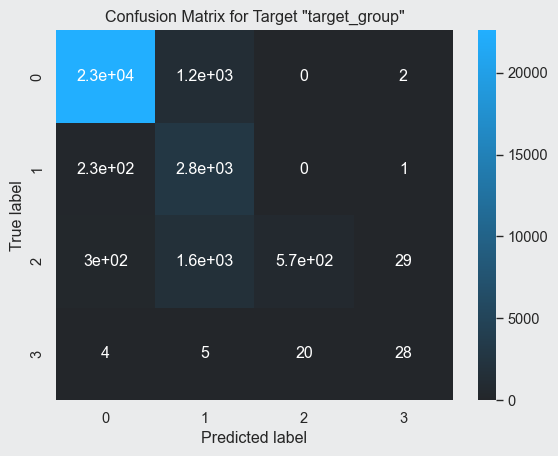

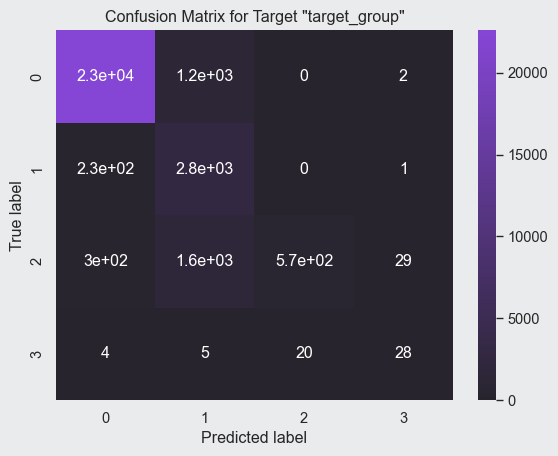

In [43]:
simple_confusion_matrix(y_true_attack_group, y_pred_attack_group, 'target_group')